In [0]:
# !pip install category_encoders

In [0]:
# https://lambdaschool.github.io/ds/unit2/portfolio-project/ds14
# https://finance.yahoo.com/quote/GOLD/history?p=GOLD (Gold)
# GOLD (47B cap) has 15 more years of historical data than GLD, GDX, and GC=F

import pandas_datareader as web
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
plt.style.use('fivethirtyeight')

# yahoo_gold_url = 'https://query1.finance.yahoo.com/v7/finance/download/GOLD?period1=476323200&period2=1587600000&interval=1d&events=history'
# For whatever reason, use datareader to import data below for better plot with dates.
# Another advantage of using pandas_datareader is specifying current date as above URL is fixed dates.
gold = web.DataReader('GOLD', data_source='yahoo', start='1985-02-04', end='2020-04-28')
# However, beware of issues with dates in models later.

# gold = pd.read_csv(yahoo_gold_url)

gold

# - [X] Continue to iterate on your project: data cleaning, exploratory visualization, feature engineering, modeling.
# - [X] Make at least 1 partial dependence plot to explain your model.
# - [X] Make at least 1 Shapley force plot to explain an individual prediction.
# - [X] **Share at least 1 visualization (of any type) on Slack!**

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
1985-02-04,0.581370,0.552300,0.552300,0.552300,50400.0,0.356190
1985-02-05,0.610440,0.552300,0.552300,0.552300,18400.0,0.356190
1985-02-06,0.654060,0.581370,0.581370,0.581370,65600.0,0.374938
1985-02-07,0.610440,0.581370,0.581370,0.581370,40000.0,0.374938
1985-02-08,0.610440,0.581370,0.581370,0.581370,25600.0,0.374938
...,...,...,...,...,...,...
2020-04-22,26.580000,25.570000,25.650000,26.480000,21034500.0,26.480000
2020-04-23,28.500000,26.570000,26.940001,26.740000,30865400.0,26.740000
2020-04-24,27.670000,26.799999,27.250000,27.100000,27633700.0,27.100000


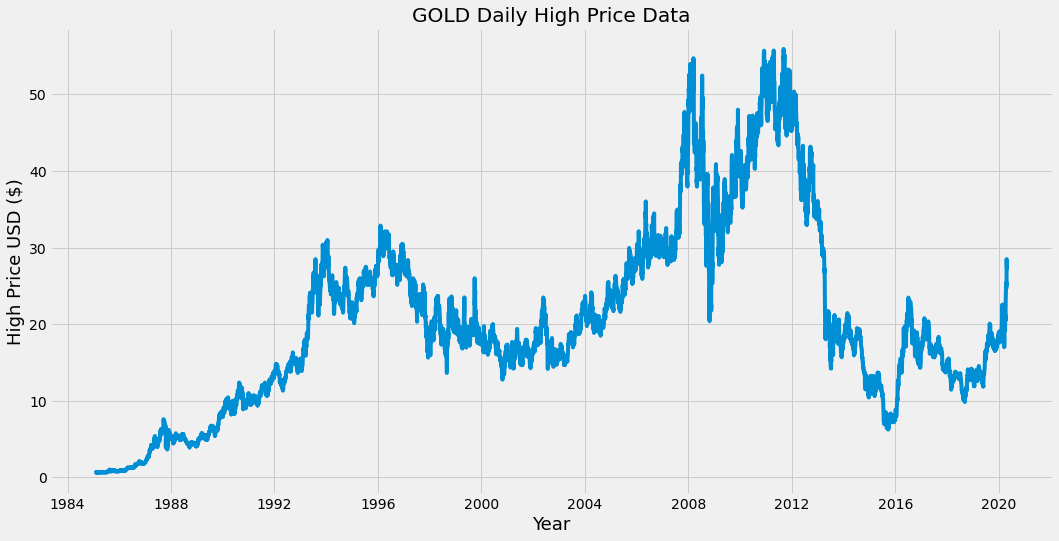

In [0]:
# Visualize the high price
plt.figure(figsize=(16,8))
plt.title('GOLD Daily High Price Data')
plt.plot(gold['High'])
plt.xlabel('Year', fontsize=18)
plt.ylabel('High Price USD ($)', fontsize=18)
plt.show()

In [0]:
# No NaNs
# gold.isna().sum()

In [0]:
# Calculations for train, val, test, sizes to do manual split and avoid data leakage
trainsize = .6*8876
valsize = .2*8876
testsize = .2*8876

(trainsize, valsize, testsize)

(5325.599999999999, 1775.2, 1775.2)

In [0]:
# Calculation for val rows
valend = 5325.599999999999 + 1775.2
valend

7100.799999999999

In [0]:
train = gold.iloc[0:5325]
val = gold.iloc[5326:7100]
test = gold.iloc[7101:8876]

(train.shape, val.shape, test.shape)

((5325, 6), (1774, 6), (1775, 6))

In [0]:
# train = gold

In [0]:
# Split train into train & test
# This method causes data leakage
#from sklearn.model_selection import train_test_split

#train, test = train_test_split(train, train_size=0.80, test_size=0.20, random_state=42)

#(train.shape, test.shape)

In [0]:
# Split train into train and val
# This method causes data leakage
#train, val = train_test_split(train, train_size=0.80, test_size=0.20, random_state=42)

#(train.shape, val.shape)

In [0]:
# Add New Columns with Average Prices
# This feature has the most permutation importance
train['HL Avg'] = (train['High'] + train['Low'])/2
val['HL Avg'] = (val['High'] + val['Low'])/2
test['HL Avg'] = (test['High'] + test['Low'])/2
# Testing this new feature (made score worse, but has 3rd highest permuation imporance)
train['OC Avg'] = (train['Open'] + train['Close'])/2
val['OC Avg'] = (val['Open'] + val['Close'])/2
test['OC Avg'] = (test['Open'] + test['Close'])/2
# Test another feature
train['HL Range'] = (train['High'] - train['Low'])
val['HL Range'] = (val['High'] - val['Low'])
test['HL Range'] = (test['High'] - test['Low'])
# Another one (Consider using an if statement, whichever one is higher, then subtract the smaller one, for a true range)
train['OC Range'] = (train['Open'] - train['Close'])
val['OC Range'] = (val['Open'] - val['Close'])
test['OC Range'] = (test['Open'] - test['Close'])

In [0]:
# Convert Date column to datetime format

#train['Date'] = pd.to_datetime(train['Date'], infer_datetime_format=True)
#val['Date'] = pd.to_datetime(val['Date'], infer_datetime_format=True)
#test['Date'] = pd.to_datetime(test['Date'], infer_datetime_format=True)

# Commented out because it caused a slightly worse MAE score.

In [0]:
# Extract components from Date

#train['year'] = train['Date'].dt.year
#train['month'] = train['Date'].dt.month
#train['day'] = train['Date'].dt.day

#val['year'] = val['Date'].dt.year
#val['month'] = val['Date'].dt.month
#val['day'] = val['Date'].dt.day

#test['year'] = test['Date'].dt.year
#test['month'] = test['Date'].dt.month
#test['day'] = test['Date'].dt.day

# Commented out because it caused a slightly worse MAE score.

In [0]:
# Drop the original Date column
# train = train.drop(columns=['Date'])
# val = val.drop(columns=['Date'])
# test = test.drop(columns=['Date'])

In [0]:
# Assign 'High' price to target variable
target = 'High'

In [0]:
# How is the target distributed?
y = train['High']

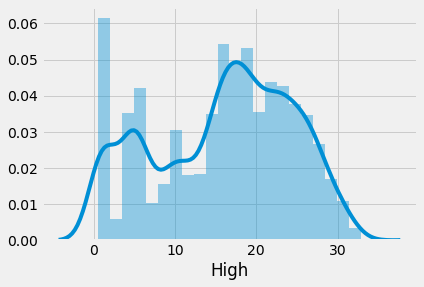

In [0]:
# Looks pretty normal
import seaborn as sns
sns.distplot(y);

In [0]:
# No outliers
y.describe()

count    5325.000000
mean       15.934572
std         8.482397
min         0.546875
25%         9.312500
50%        17.160000
75%        22.687500
max        32.875000
Name: High, dtype: float64

In [0]:
# Arrange data into X features matrix and y target vector 
X_train = train.drop(columns=target)
y_train = train[target]
X_val = val.drop(columns=target)
y_val = val[target]
X_test = test

In [0]:
# Linear Regression Val
from sklearn.linear_model import LinearRegression
import category_encoders as ce
import plotly.express as px
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error

pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    LinearRegression()
)

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_val)
mae = mean_absolute_error(y_val, y_pred)
print(f'Validation MAE: ${mae:}')

Validation MAE: $1.606146198077802e-08


In [0]:
features = X_train.columns.tolist()

In [0]:
coefficients = pipeline.named_steps['linearregression'].coef_
pd.Series(coefficients, features)

Low          3.333333e-01
Open        -1.169412e-11
Close        3.892692e-12
Volume      -2.044954e-15
Adj Close    1.507281e-16
HL Avg       6.666667e-01
OC Avg       7.790747e-12
HL Range     6.666667e-01
OC Range     7.793182e-12
dtype: float64

In [0]:
# Linear Regression Test
X_test = test.drop(columns=target)
y_test = test[target]

y_pred = pipeline.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f'Test MAE: ${mae:}')

Test MAE: $2.9073310696243342e-08


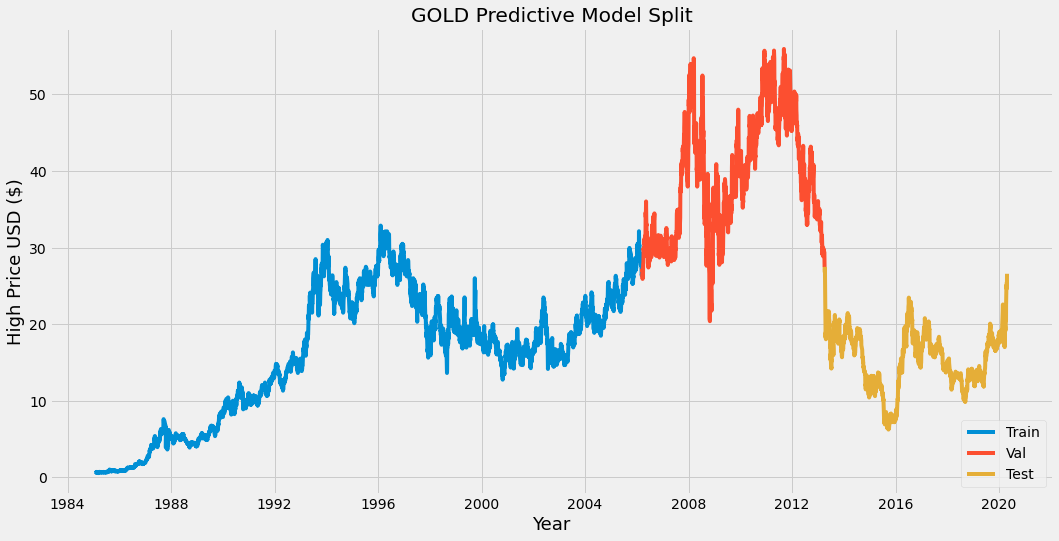

In [0]:
# Plot the data
train = gold.iloc[0:5326]
val = gold.iloc[5326:7101]
test = gold.iloc[7101:8876] 
# Visualize the data
plt.figure(figsize=(16,8))
plt.title('GOLD Predictive Model Split')
plt.xlabel('Year', fontsize=18)
plt.ylabel('High Price USD ($)', fontsize=18)
plt.plot(train['High'])
plt.plot(val['High'])
plt.plot(test['High'])
### plt.plot(gold) trying to compare
plt.legend(['Train', 'Val', 'Test'], loc = 'lower right')
plt.show()